In [1]:
!nvidia-smi

Wed Aug 17 16:16:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -qU livelossplot
!pip install -qU torchmetrics

# final set
# https://drive.google.com/file/d/1tcPv-KT09eMgYcM3YQVoRmIjdEb_Wgtc/view?usp=sharing
!gdown 1tcPv-KT09eMgYcM3YQVoRmIjdEb_Wgtc
!unzip -qq './document_dataset_resized.zip'

     |████████████████████████████████| 1.6 MB 11.4 MB/s 
     |████████████████████████████████| 419 kB 13.6 MB/s 
Downloading...
From: https://drive.google.com/uc?id=1tcPv-KT09eMgYcM3YQVoRmIjdEb_Wgtc
To: /content/document_dataset_resized.zip
100% 1.50G/1.50G [00:20<00:00, 72.4MB/s]


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torchvision.models as models
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import albumentations as A
import PIL

from torchvision.utils import make_grid, save_image
from torchmetrics import MeanMetric
from livelossplot import PlotLosses

In [4]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


# For reproducibility
seed = 41
seed_everything(seed)

In [5]:
DATA_DIR = r"./document_dataset_resized"

BESTMODEL_PATH = r"model_mbv3_iou_mix_2C_aux.pth"  # path to save model weights

IMAGE_SIZE = 384
NUM_WORKERS = 2

# Dataset Preparation

In [6]:
import torchvision.transforms as torchvision_T 

def train_transforms(mean=(0.4611, 0.4359, 0.3905), 
                      std=(0.2193, 0.2150, 0.2109)
):
    transforms = torchvision_T.Compose([
        torchvision_T.ToTensor(),
        torchvision_T.RandomGrayscale(p=0.4),                                        
        torchvision_T.Normalize(mean, std),
    ])
    
    return transforms


def common_transforms(mean=(0.4611, 0.4359, 0.3905), 
                       std=(0.2193, 0.2150, 0.2109)
):
    transforms = torchvision_T.Compose([
        torchvision_T.ToTensor(),
        torchvision_T.Normalize(mean, std),
    ])
    
    return transforms


class SegDataset(Dataset):
    def __init__(self, *, 
                 img_paths, 
                 mask_paths, 
                 image_size=(384, 384),  
                 data_type="train"
    ):
        self.data_type  = data_type
        self.img_paths  = img_paths
        self.mask_paths = mask_paths
        self.image_size = image_size


        if self.data_type == "train":
            self.transforms = train_transforms()
        else:
            self.transforms = common_transforms()

    def read_file(self, path):
        file = cv2.imread(path)[:, :, ::-1]
        file = cv2.resize( file, 
                           self.image_size,                 
                           interpolation=cv2.INTER_NEAREST
                        )
        return file

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        
        image_path = self.img_paths[index]
        image = self.read_file(image_path)
        image = self.transforms(image)

        mask_path = self.mask_paths[index]
        
        gt_mask = self.read_file(mask_path).astype(np.int32)

        _mask = np.zeros((*self.image_size, 2), dtype=np.float32)
        
	   # BACKGROUND
        _mask[:, :, 0] = np.where(gt_mask[:, :, 0] == 0,   1.0, 0.0) 
	   # DOCUMENT
        _mask[:, :, 1] = np.where(gt_mask[:, :, 0] == 255, 1.0, 0.0)  

        mask = torch.from_numpy(_mask).permute(2, 0, 1)

        return image, mask


In [7]:
def get_dataset(data_directory, batch_size=16):

    train_img_dir = os.path.join(data_directory, "train", "images")
    train_msk_dir = os.path.join(data_directory, "train", "masks")

    valid_img_dir = os.path.join(data_directory, "valid", "images")
    valid_msk_dir = os.path.join(data_directory, "valid", "masks")
 
 
    train_img_paths = [os.path.join(train_img_dir, i) for i in os.listdir(train_img_dir)]
    train_msk_paths = [os.path.join(train_msk_dir, i) for i in os.listdir(train_msk_dir)]

    valid_img_paths = [os.path.join(valid_img_dir, i) for i in os.listdir(valid_img_dir)]
    valid_msk_paths = [os.path.join(valid_msk_dir, i) for i in os.listdir(valid_msk_dir)]

    train_ds = SegDataset(img_paths=train_img_paths, mask_paths=train_msk_paths, data_type="train")
    valid_ds = SegDataset(img_paths=valid_img_paths, mask_paths=valid_msk_paths, data_type="valid")

    train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=NUM_WORKERS, shuffle=True,  pin_memory=True)
    valid_loader = DataLoader(valid_ds, batch_size=batch_size, num_workers=NUM_WORKERS, shuffle=False, pin_memory=True)

    return train_loader, valid_loader

In [8]:
train_loader, valid_loader = get_dataset(DATA_DIR, batch_size=1)

In [9]:
for i, j in valid_loader:
    print(i.shape, j.shape, j.dtype)
    break

torch.Size([1, 3, 384, 384]) torch.Size([1, 2, 384, 384]) torch.float32


In [10]:
def denormalize(tensors, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    """Normalization parameters for pre-trained PyTorch models
     Denormalizes image tensors using mean and std """

    for c in range(3):
        tensors[:,c, :, :].mul_(std[c]).add_(mean[c])

    return torch.clamp(tensors, min=0., max=1.)

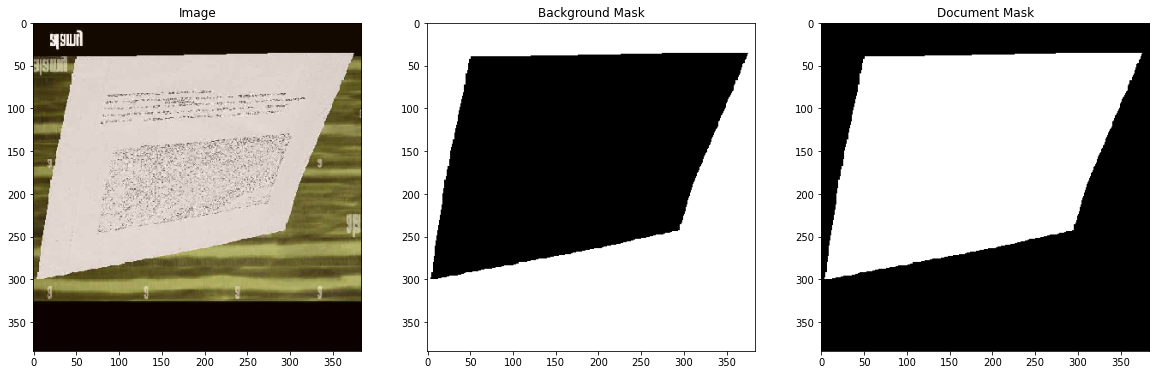

In [11]:
for image, mask in valid_loader:
    image = denormalize(image)
    image = image[0]
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    x = image.permute(1, 2, 0).numpy()
    plt.imshow(x)
    plt.title('Image')
    
    labels = mask[0]
    
    plt.subplot(1, 3, 2)
    plt.imshow(labels[0].numpy(), cmap='gray')
    plt.title("Background Mask")
    
    plt.subplot(1, 3, 3)
    plt.imshow(labels[1].numpy(), cmap='gray')
    plt.title("Document Mask")
    
    plt.show()        
    plt.close()

    break

# Create Model

In [12]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models.segmentation import deeplabv3_resnet101 

def prepare_model(backbone_model="mbv3", num_classes=2):

    # Initialize model with pre-trained weights.
    weights = 'DEFAULT'
    if backbone_model == "mbv3":
        model = deeplabv3_mobilenet_v3_large(weights=weights)
    elif backbone_model == "r50":
        model = deeplabv3_resnet50(weights=weights)
    elif backbone_model == "r101":
        model = deeplabv3_resnet101(weights=weights)
    else:
        raise ValueError("Wrong backbone model passed. Must be one of 'mbv3', 'r50' and 'r101' ")

    # Update the number of output channels for the output layer.
    # This will remove the pre-trained weights for the last layer.
    model.classifier[4]     = nn.LazyConv2d(num_classes, 1)
    model.aux_classifier[4] = nn.LazyConv2d(num_classes, 1)
    return model

In [13]:
# Testing

model = prepare_model(num_classes=2)

model.train()
out = model(torch.randn((2, 3, 384, 384)))
out['out'].shape

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth


  0%|          | 0.00/42.3M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([2, 2, 384, 384])

# Loss and Metric Class

In [14]:
def intermediate_metric_calculation(
    predictions, targets, use_dice=False, smooth=1e-6, dims=(2, 3)
):
    # dimscorresponding to image height and width: [B, C, H, W].
    
    # Intersection: |G ∩ P|. Shape: (batch_size, num_classes)
    intersection = (predictions * targets).sum(dim=dims) + smooth 

    # Summation: |G| + |P|. Shape: (batch_size, num_classes).
    summation = (predictions.sum(dim=dims) + targets.sum(dim=dims)) + smooth 
        
    if use_dice:
        # Dice Shape: (batch_size, num_classes) 
        metric = (2.0 * intersection) / summation
    else:
        # Union. Shape: (batch_size, num_classes)
        union = summation - intersection

        # IoU Shape: (batch_size, num_classes)
        metric = intersection /  union
        
    # Compute the mean over the remaining axes (batch and classes). 
    # Shape: Scalar
    total = metric.mean()
    
    return total

In [15]:
class Loss(nn.Module):
    def __init__(self, smooth=1e-6, use_dice=False):
        super().__init__()
        self.smooth = smooth
        self.use_dice = use_dice


    def forward(self, predictions, targets):
        # predictions --> (B, #C, H, W) unnormalized
        # targets     --> (B, #C, H, W) one-hot encoded

        # Normalize model predictions
        predictions = torch.sigmoid(predictions)

        # Calculate pixel-wise loss for both channels. Shape: Scalar
        pixel_loss = F.binary_cross_entropy(predictions, targets, reduction="mean")
        
        mask_loss  = 1 - intermediate_metric_calculation(predictions, targets, use_dice=self.use_dice, smooth=self.smooth)
        total_loss = mask_loss + pixel_loss
        
        return total_loss

In [16]:
def convert_2_onehot(matrix, num_classes=3):
    '''
    Perform one-hot encoding across the channel dimension.
    '''
    matrix = matrix.permute(0, 2, 3, 1)
    matrix = torch.argmax(matrix, dim=-1)
    matrix = torch.nn.functional.one_hot(matrix, num_classes=num_classes)
    matrix = matrix.permute(0, 3, 1, 2)

    return matrix

class Metric(nn.Module):
    def __init__(self, num_classes=3, smooth=1e-6, use_dice=False):
        super().__init__()
        self.num_classes = num_classes
        self.smooth      = smooth
        self.use_dice    = use_dice
    
    def forward(self, predictions, targets):
        # predictions  --> (B, #C, H, W) unnormalized
        # targets      --> (B, #C, H, W) one-hot encoded 

        # Converting unnormalized predictions into one-hot encoded across channels.
        # Shape: (B, #C, H, W) 
        predictions = convert_2_onehot(predictions, num_classes=self.num_classes) # one hot encoded

        metric = intermediate_metric_calculation(predictions, targets, use_dice=self.use_dice, smooth=self.smooth)
        
        # Compute the mean over the remaining axes (batch and classes). Shape: Scalar
        return metric

# Training Helper Functions 

In [17]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

def get_default_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
def step(model, epoch_num=None, loader=None, optimizer_fn=None, loss_fn=None, metric_fn=None, is_train=False, metric_name="iou"):

    loss_record   = MeanMetric()
    metric_record = MeanMetric()
    
    loader_len = len(loader)

    text = "Train" if is_train else "Valid"

    for data in tqdm(iterable=loader, total=loader_len, dynamic_ncols=True, desc=f"{text} :: Epoch: {epoch_num}"):
        
        if is_train:
            preds = model(data[0])["out"]
        else:
            with torch.no_grad():
                preds = model(data[0])["out"].detach()

        loss = loss_fn(preds, data[1])

        if is_train:
            optimizer_fn.zero_grad()
            loss.backward()
            optimizer_fn.step()

        metric = metric_fn(preds.detach(), data[1])

        loss_value = loss.detach().item()
        metric_value = metric.detach().item()
        
        loss_record.update(loss_value)
        metric_record.update(metric_value)

    current_loss   = loss_record.compute()
    current_metric = metric_record.compute()

    # print(f"\rEpoch {epoch:>03} :: TRAIN :: LOSS: {loss_record.compute()}, {metric_name.upper()}: {metric_record.compute()}\t\t\t\t", end="")

    return current_loss, current_metric

# Training 

In [20]:
NUM_EPOCHS = 2 # 50
BATCH_SIZE = 64
NUM_CLASSES = 2

device = get_default_device()

backbone_model_name = "mbv3" # mbv3 | r50 | r101

model = prepare_model(backbone_model=backbone_model_name, num_classes=NUM_CLASSES)
model.to(device)

# Dummy pass through the model
_ = model(torch.randn((2, 3, 384, 384), device=device))


train_loader, valid_loader = get_dataset(data_directory=DATA_DIR, batch_size=BATCH_SIZE)
train_loader = DeviceDataLoader(train_loader, device)
valid_loader = DeviceDataLoader(valid_loader, device)

metric_name = "iou"
use_dice = True if metric_name == "dice" else False 

metric_fn = Metric(num_classes=NUM_CLASSES, use_dice=use_dice).to(device)
loss_fn   = Loss(use_dice=use_dice).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


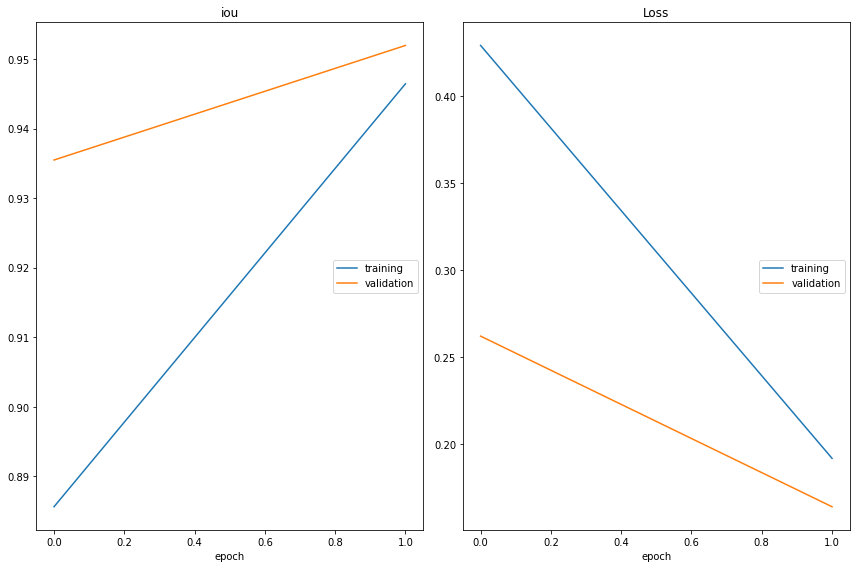

iou
	training         	 (min:    0.886, max:    0.946, cur:    0.946)
	validation       	 (min:    0.935, max:    0.952, cur:    0.952)
Loss
	training         	 (min:    0.192, max:    0.429, cur:    0.192)
	validation       	 (min:    0.164, max:    0.262, cur:    0.164)

Saving model.....


In [21]:
liveloss = PlotLosses()  

best_metric = 0.0

for epoch in range(1, NUM_EPOCHS + 1):

    logs = {}

    model.train()
    train_loss, train_metric = step(model, 
                                    epoch_num=epoch, 
                                    loader=train_loader, 
                                    optimizer_fn=optimizer, 
                                    loss_fn=loss_fn, 
                                    metric_fn=metric_fn, 
                                    is_train=True,
                                    metric_name=metric_name,
                                    )

    model.eval()
    valid_loss, valid_metric = step(model, 
                                    epoch_num=epoch, 
                                    loader=valid_loader, 
                                    loss_fn=loss_fn, 
                                    metric_fn=metric_fn, 
                                    is_train=False,
                                    metric_name=metric_name,
                                    )

    logs['loss']               = train_loss
    logs[metric_name]          = train_metric
    logs['val_loss']           = valid_loss
    logs[f'val_{metric_name}'] = valid_metric

    liveloss.update(logs)
    liveloss.send()

    if valid_metric >= best_metric:
        print("\nSaving model.....")
        torch.save(model.state_dict(), BESTMODEL_PATH)
        best_metric = valid_metric